In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [6]:
BATCH_SIZE = 32
EPOCHS = 2
NUM_USERS = 1
NUM_IMAGES_PER_USER = 20

In [7]:
def build_cgan():
    
    # Generator network
    generator = models.Sequential()
    generator.add(layers.Dense(256, activation='relu', input_dim=101))  # 101 is the total dimension after concatenation
    generator.add(layers.Reshape((8, 8, 4)))
    
    generator.add(layers.Conv2DTranspose(316, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    generator.add(layers.BatchNormalization())
    
    generator.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    generator.add(layers.BatchNormalization())
    
    generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    generator.add(layers.BatchNormalization())
    
    generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    generator.add(layers.BatchNormalization())
    
    generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(4, 4), padding='same', activation='tanh'))

    # Discriminator network
    discriminator = models.Sequential()
    discriminator.add(layers.Input(shape=(256, 256, 1)))
    
    discriminator.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    discriminator.add(layers.BatchNormalization())
    
    discriminator.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    discriminator.add(layers.BatchNormalization())

#     discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1, activation='sigmoid'))

    return generator, discriminator


# Define user ID and noise input layers
user_id_input = layers.Input(shape=(1,), dtype=tf.int32)
noise_input = layers.Input(shape=(100,))

# Create cGAN model
generator, discriminator = build_cgan()

# Define loss functions and optimizers for generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Training loop
@tf.function
def train_step(images, user_ids):
    noise = tf.random.normal([BATCH_SIZE, 100])
    user_id_float = layers.Lambda(lambda x: tf.cast(x, tf.float32))(user_ids)
    user_id_float = tf.reshape(user_id_float, (BATCH_SIZE, 1))
    # print(noise.shape, user_id_float.shape)
    concatenated_inputs = tf.concat([user_id_float, noise], axis=1)  # Concatenate user ID and noise
    # print(concatenated_inputs.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(concatenated_inputs, training=True)
        # print(generated_images)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [8]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               26112     
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 4)           0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 316)        31916     
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 316)        1264      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 256)      2022656   
 ranspose)                                                       
                                                      

In [9]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1664      
                                                                 
 batch_normalization_10 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     204928    
                                                                 
 batch_normalization_11 (Bat  (None, 256, 256, 128)    512       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256, 256, 1)       129       
                                                                 
Total params: 207,489
Trainable params: 207,105
Non-tr

In [ ]:
# MEMORY EFFICIENT CODE

augmented_data_folder = r'datasets\jabcode_exchange_replace_augmented'

# # Initialize empty lists to store user data and user IDs
# user_data = []
# user_ids = []

user_ids_mapping = {}
for i in range(1, NUM_USERS+1):
    user_ids_mapping[i] = np.array([i] * BATCH_SIZE, dtype=np.int32)

# Loop through the folders for each user
for user_id in range(1, NUM_USERS + 1):
    user_data_folder = os.path.join(augmented_data_folder, f'user_{user_id}')
    
    user_images = []  # To store images for the current user
#     user_id_array = np.array([user_id] * NUM_IMAGES_PER_USER, dtype=np.int32)  # User IDs for the current user
    
    for image_id in range(1, NUM_IMAGES_PER_USER+1):
        image_filename = f'jabcode_user_{user_id}_augmented_{image_id}.png'
        image_path = os.path.join(user_data_folder, image_filename)
        
        # Load and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        image = cv2.resize(image, (256, 256))  # Resize if needed
        image = np.reshape(image, (256, 256, 1))
        # print(image.shape)
#         user_images.append(image)
    
        # Main training loop
        for epoch in range(EPOCHS):
            print('***********************************************************************************************************')
            print(f'user_id {user_id}\n')
            print(f'    Epoch {epoch+1}')

            print(user_ids_mapping[user_id])
            train_step(image, user_ids_mapping[user_id])
        print('***********************************************************************************************************')
        

In [141]:
augmented_data_folder = os.path.join('datasets', 'augmented_jabcode')

NUM_USERS = 10
NUM_IMAGES_PER_USER = 10

# Initialize empty lists to store user data and user IDs
user_data = []
user_ids = []

# Loop through the folders for each user
for user_id in range(1, NUM_USERS + 1):
    user_data_folder = os.path.join(augmented_data_folder, f'user_{user_id}')
    
    user_images = []  # To store images for the current user
    user_id_array = np.array([user_id] * NUM_IMAGES_PER_USER, dtype=np.int32)  # User IDs for the current user
    
    for image_id in range(NUM_IMAGES_PER_USER):
        image_filename = f'jabcode_user_{user_id}_augmented_{image_id}.png'
        image_path = os.path.join(user_data_folder, image_filename)
        # Load and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        image = cv2.resize(image, (256, 256))  # Resize if needed
        image = np.reshape(image, (256, 256, 1))
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        # print(image.shape)
        user_images.append(image)
    
    user_data.append(user_images)
    user_ids.append(user_id_array)

# Now you have user_data, a list of lists containing user-specific images, and user_ids, a list of user IDs corresponding to each user's images.

# You can use these arrays to train your cGAN.

# Assuming you have already loaded and organized your data as user_data and user_ids

# Create a user ID to condition mapping

if os.path.exists('checkpoints/discriminator/my_checkpoint.index') and \
    os.path.exists('checkpoints/generator/my_checkpoint.index') == True:
    generator.load_weights('./checkpoints/generator/my_checkpoint')
    discriminator.load_weights('./checkpoints/discriminator/my_checkpoint')

else:
    user_ids_mapping = {}
    for i in range(NUM_USERS):
        user_ids_mapping[i] = np.array([i] * BATCH_SIZE, dtype=np.int32)

    # Main training loop
    for epoch in range(EPOCHS):
        for user_id in range(NUM_USERS):
            for batch_images in user_data[user_id]:
                train_step(batch_images, user_ids_mapping[user_id])
    
    generator.save_weights('./checkpoints/generator/my_checkpoint')
    discriminator.save_weights('./checkpoints/discriminator/my_checkpoint')

----- ----- ----- ----- user_1.png ----- ----- ----- -----


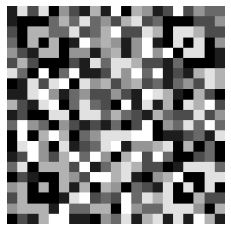

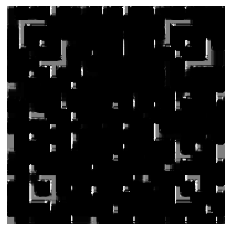

----- ----- ----- ----- user_2.png ----- ----- ----- -----


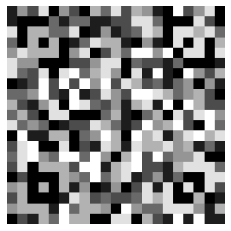

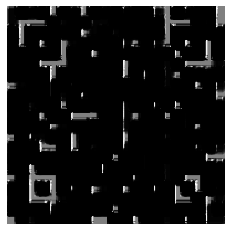

----- ----- ----- ----- user_3.png ----- ----- ----- -----


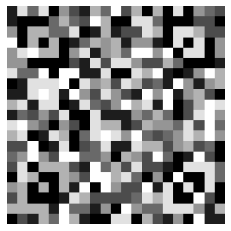

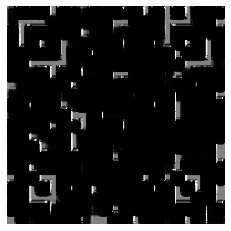

----- ----- ----- ----- user_4.png ----- ----- ----- -----


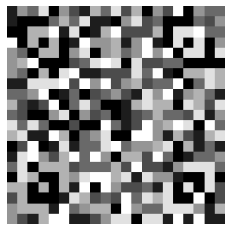

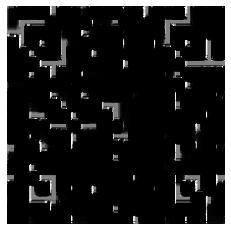

----- ----- ----- ----- user_5.png ----- ----- ----- -----


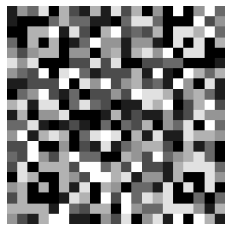

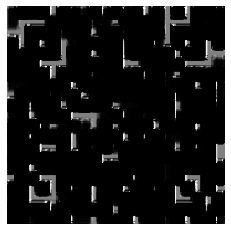

----- ----- ----- ----- user_6.png ----- ----- ----- -----


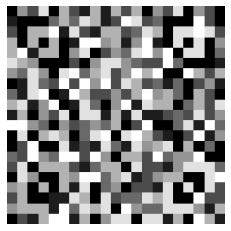

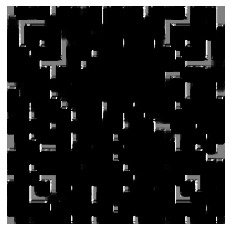

----- ----- ----- ----- user_7.png ----- ----- ----- -----


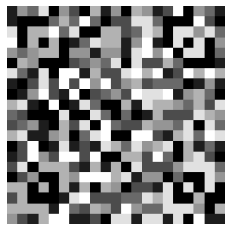

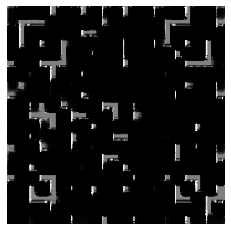

----- ----- ----- ----- user_8.png ----- ----- ----- -----


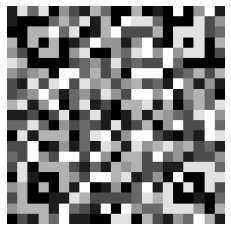

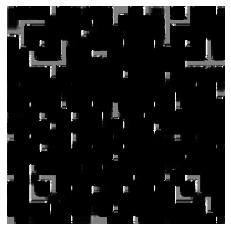

----- ----- ----- ----- user_9.png ----- ----- ----- -----


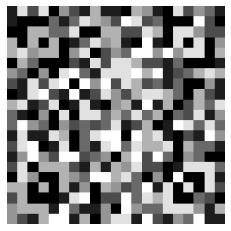

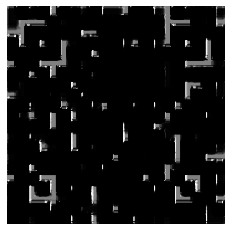

----- ----- ----- ----- user_10.png ----- ----- ----- -----


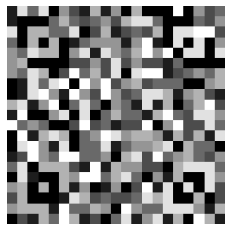

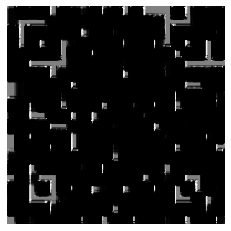

In [142]:
for index in range(1, 11):
    folder_name, file_name = f'user_{index}', f'user_{index}.png'
    image_filename = os.path.join('datasets', 'jabcode', folder_name, file_name)
    # print(image_filename)
    print(f'----- ----- ----- ----- {file_name} ----- ----- ----- -----')
    image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    image = cv2.resize(image, (256, 256))  # Resize if needed
    image = np.reshape(image, (256, 256, 1))
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)
    
    save_dir = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name)
    if os.path.exists(save_dir) == False:
        os.makedirs(save_dir)
    
    inp_img = np.reshape(image, (256, 256))
    plt.imshow(inp_img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    disc_op = discriminator.predict(image)
    disc_op = np.reshape(disc_op, (256, 256))
    plt.imshow(disc_op, cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(save_dir, file_name), bbox_inches='tight', pad_inches=0)
#     plt.imshow(image[0])
    
    plt.show()

COSINE SIMILARITY

In [2]:
def calculate_cosine_similarity(image1, image2):
    # Flatten the images to 1D arrays
    img1_vector = image1.flatten()
    img2_vector = image2.flatten()
    if np.array_equal(img1_vector, img2_vector):
        print('equal vectors')
    # Compute cosine similarity
    dot_product = np.dot(img1_vector, img2_vector)
    norm_img1 = np.linalg.norm(img1_vector, ord=2)
    norm_img2 = np.linalg.norm(img2_vector, ord=2)
    
    similarity = dot_product / (norm_img1 * norm_img2)
    return similarity

In [12]:
img11 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_XOR', 'user_1', '1.png')
img12 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_XOR', 'user_1', '2.png')

img21 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_XOR', 'user_2', '1.png')
img22 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_XOR', 'user_2', '2.png')

img11 = cv2.imread(img11)
img12 = cv2.imread(img12)
img21 = cv2.imread(img21)
img22 = cv2.imread(img22)

In [13]:
calculate_cosine_similarity(img11, img12)

equal vectors


1.3943908258565518e-08

In [14]:
calculate_cosine_similarity(img22, img22)

equal vectors


2.7141806572704937e-09

In [15]:
calculate_cosine_similarity(img11, img21)

5.502456620975966e-09

In [16]:
calculate_cosine_similarity(img11, img22)

5.502456620975966e-09

In [17]:
calculate_cosine_similarity(img12, img21)

5.502456620975966e-09

In [18]:
calculate_cosine_similarity(img12, img22)

5.502456620975966e-09

In [145]:
# distance_metric = []

for index_i in range(1, 11):
    folder_name, file_name_i = f'user_{index_i}', f'user_{index_i}.png'
    image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_i)
    # print(image_filename)
    
    image_i = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    
    for index_j in range(1, 11):
        folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
        image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
        # print(image_filename)

        image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        similarity_score = calculate_cosine_similarity(image_i, image_j)
        # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
        print(f'Cosine Similarity between the images {file_name_i} and {file_name_j} is {similarity_score}')
        # distance_metric.append(similarity_score)

#UNCOMMENT THIS FOR DISSIMILARITY
#         if index_j != index_i:
#             folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
#             image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
#             # print(image_filename)

#             image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#             similarity_score = calculate_cosine_similarity(image_i, image_j)
#             # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
#             print(f'Cosine Similarity between the images {file_name_i} and {file_name_j} is {similarity_score}')
#             # distance_metric.append(similarity_score)       
    print('\n\n')

equal vectors
Cosine Similarity between the images user_1.png and user_1.png is 2.1907067154142726e-07
Cosine Similarity between the images user_1.png and user_2.png is 9.973084647050451e-08
Cosine Similarity between the images user_1.png and user_3.png is 5.734738176955671e-07
Cosine Similarity between the images user_1.png and user_4.png is 1.2850042711074213e-06
Cosine Similarity between the images user_1.png and user_5.png is 9.080944052010485e-07
Cosine Similarity between the images user_1.png and user_6.png is 2.995768095252291e-06
Cosine Similarity between the images user_1.png and user_7.png is 1.8781861537210577e-06
Cosine Similarity between the images user_1.png and user_8.png is 8.022588223149031e-07
Cosine Similarity between the images user_1.png and user_9.png is 1.8916634479779955e-07
Cosine Similarity between the images user_1.png and user_10.png is 7.299536432018359e-07



Cosine Similarity between the images user_2.png and user_1.png is 9.973084647050451e-08
equal vect

Cosine Similarity between the images user_10.png and user_3.png is 3.5309025346654364e-07
Cosine Similarity between the images user_10.png and user_4.png is 3.262946010481372e-07
Cosine Similarity between the images user_10.png and user_5.png is 1.258405327073025e-06
Cosine Similarity between the images user_10.png and user_6.png is 1.1536572167523883e-06
Cosine Similarity between the images user_10.png and user_7.png is 2.925594003119345e-06
Cosine Similarity between the images user_10.png and user_8.png is 8.705705287250396e-08
Cosine Similarity between the images user_10.png and user_9.png is 9.606809626296175e-07
equal vectors
Cosine Similarity between the images user_10.png and user_10.png is 1.2291340664462503e-07





SSIM

In [146]:
from skimage.metrics import structural_similarity as ssim

def calculate_SSIM(image1, image2):
    similarity_index, _ = ssim(image1, image2, full=True)
    return similarity

In [147]:
# distance_metric = []

for index_i in range(1, 11):
    folder_name, file_name_i = f'user_{index_i}', f'user_{index_i}.png'
    image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_i)
    # print(image_filename)
    
    image_i = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    
    for index_j in range(1, 11):
        folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
        image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
        # print(image_filename)

        image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        similarity_score = calculate_SSIM(image_i, image_j)
        # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
        print(f'SSIM between the images {file_name_i} and {file_name_j} is {similarity_score}')
        # distance_metric.append(similarity_score)

# UNCOMMENT THIS FOR DISSIMILAIRITY
#         if index_j != index_i:
#             folder_name, file_name = f'user_{index_j}', f'user_{index_j}.png'
#             image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name)
#             # print(image_filename)

#             image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#             similarity_score = calculate_SSIM(image_i, image_j)
#             # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
#             # print(similarity)
#             print(f'SSIM between the images user_{index_i}.png and user_{index_j}.png is {similarity_score}')
#             # distance_metric.append(similarity_score)       
    print('\n\n')

SSIM between the images user_1.png and user_1.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_2.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_3.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_4.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_5.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_6.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_7.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_8.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_9.png is 9.606809626296175e-07
SSIM between the images user_1.png and user_10.png is 9.606809626296175e-07



SSIM between the images user_2.png and user_1.png is 9.606809626296175e-07
SSIM between the images user_2.png and user_2.png is 9.606809626296175e-07
SSIM between the images user_2.png and user_3.png is 9.606809626296175e-07
SSIM between the imag

PIXELWISE

In [19]:
def compare_images_pixelwise(image1, image2):
    # Check if the images have the same dimensions
    if image1.shape == image2.shape:
        # Compute pixel-wise difference
        difference = cv2.absdiff(image1, image2)
        
        # Calculate the percentage of similarity (lower percentage means higher similarity)
        similarity_percentage = (np.sum(difference) / (image1.size))
        
        # plt.imshow(difference)
        # plt.show()
        
        return similarity_percentage
    else:
        return "Images have different dimensions"

In [36]:
img11 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_1', '1.png')
img12 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_1', '2.png')

img21 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_2', '1.png')
img22 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_2', '2.png')

img11 = cv2.imread(img11)
img12 = cv2.imread(img12)
img21 = cv2.imread(img21)
img22 = cv2.imread(img22)

In [37]:
compare_images_pixelwise(img11, img12)

0.0

In [38]:
compare_images_pixelwise(img22, img22)

0.0

In [39]:
compare_images_pixelwise(img11, img21)

37.4687158814143

In [40]:
compare_images_pixelwise(img11, img22)

37.4687158814143

In [41]:
compare_images_pixelwise(img12, img21)

37.4687158814143

In [42]:
compare_images_pixelwise(img12, img22)

37.4687158814143

In [149]:
# distance_metric = []

for index_i in range(1, 11):
    folder_name, file_name_i = f'user_{index_i}', f'user_{index_i}.png'
    image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_i)
    # print(image_filename)
    
    image_i = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    
    for index_j in range(1, 11):
        folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
        image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
        # print(image_filename)

        image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        similarity_score = compare_images_pixelwise(image_i, image_j)
        # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
        print(f'Pixelwise Percentage between the images {file_name_i} and {file_name_j} is {similarity_score}')
        # distance_metric.append(similarity_score)

# UNCOMMENT THIS FOR DISSIMILAIRITY
#         if index_j != index_i:
#             folder_name, file_name = f'user_{index_j}', f'user_{index_j}.png'
#             image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name)
#             # print(image_filename)

#             image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#             similarity_score = compare_images_pixelwise(image_i, image_j)
#             # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
#             # print(similarity)
#             print(f'Pixelwise Percentage between the images user_{index_i}.png and user_{index_j}.png is {similarity_score}')
#             # distance_metric.append(similarity_score)       
    print('\n\n')

Pixelwise Percentage between the images user_1.png and user_1.png is 0.0
Pixelwise Percentage between the images user_1.png and user_2.png is 8.05423772006201
Pixelwise Percentage between the images user_1.png and user_3.png is 7.052708700545775
Pixelwise Percentage between the images user_1.png and user_4.png is 7.717534880757714
Pixelwise Percentage between the images user_1.png and user_5.png is 7.712820403915988
Pixelwise Percentage between the images user_1.png and user_6.png is 6.996602178852811
Pixelwise Percentage between the images user_1.png and user_7.png is 8.32907897810529
Pixelwise Percentage between the images user_1.png and user_8.png is 7.969844337318694
Pixelwise Percentage between the images user_1.png and user_9.png is 7.545902440060312
Pixelwise Percentage between the images user_1.png and user_10.png is 6.042451527957697



Pixelwise Percentage between the images user_2.png and user_1.png is 8.05423772006201
Pixelwise Percentage between the images user_2.png and u

Mean Square Error

In [28]:
def mse(image1, image2):
    diff = cv2.subtract(image1, image2)
    err = np.sum(diff**2)
    mse = err/(float(image1.size))
    return mse

In [43]:
img11 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_1', '1.png')
img12 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_1', '2.png')

img21 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_2', '1.png')
img22 = os.path.join(os.getcwd(), 'datasets', 'jabcode_exchange_replace', 'user_2', '2.png')

img11 = cv2.imread(img11)
img12 = cv2.imread(img12)
img21 = cv2.imread(img21)
img22 = cv2.imread(img22)

In [44]:
mse(img11, img12)

0.0

In [45]:
mse(img22, img22)

0.0

In [46]:
mse(img11, img21)

2.4265558075081883

In [47]:
mse(img11, img22)

2.4265558075081883

In [48]:
mse(img12, img21)

2.4265558075081883

In [49]:
mse(img12, img22)

2.4265558075081883

In [50]:
# distance_metric = []

for index_i in range(1, 11):
    folder_name, file_name_i = f'user_{index_i}', f'user_{index_i}.png'
    image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_i)
    # print(image_filename)
    
    image_i = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    
    for index_j in range(1, 11):
        folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
        image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
        # print(image_filename)

        image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        similarity_score = mse(image_i, image_j)
        # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
        print(f'MSE between the images {file_name_i} and {file_name_j} is {similarity_score}')
        # distance_metric.append(similarity_score)

# UNCOMMENT THIS FOR DISSIMILAIRITY
#         if index_j != index_i:
#             folder_name, file_name = f'user_{index_j}', f'user_{index_j}.png'
#             image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name)
#             # print(image_filename)

#             image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#             similarity_score = mse(image_i, image_j)
#             # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
#             # print(similarity)
#             print(f'MSE between the images user_{index_i}.png and user_{index_j}.png is {similarity_score}')
#             # distance_metric.append(similarity_score)       
    print('\n\n')

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

RMSE

In [152]:
def rmse(image1, image2):
    diff = cv2.subtract(image1, image2)
    err = np.sum(diff**2)
    mse = err/(float(image1.size))
    rmse = np.sqrt(mse)
    return rmse

In [153]:
# distance_metric = []

for index_i in range(1, 11):
    folder_name, file_name = f'user_{index_i}', f'user_{index_i}.png'
    image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name)
    # print(image_filename)
    
    image_i = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
    
    for index_j in range(1, 11):
        folder_name, file_name_j = f'user_{index_j}', f'user_{index_j}.png'
        image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name_j)
        # print(image_filename)

        image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
        similarity_score = rmse(image_i, image_j)
        # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
        print(f'MSE between the images {file_name_i} and {file_name_j} is {similarity_score}')
        # distance_metric.append(similarity_score)

# UNCOMMENT THIS FOR DISSIMILAIRITY
#         if index_j != index_i:
#             folder_name, file_name = f'user_{index_j}', f'user_{index_j}.png'
#             image_filename = os.path.join('datasets', 'jabcode_exchange_XOR', folder_name, file_name)
#             # print(image_filename)

#             image_j = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)  # Load as grayscale image
#             similarity_score = rmse(image_i, image_j)
#             # similarity_score = 0.5 * (similarity_score + 1) # UNCOMMENT THIS TO GET NORMALIZED SCORE BETWEEN 0 AND 1
#             # print(similarity)
#             print(f'MSE between the images user_{index_i}.png and user_{index_j}.png is {similarity_score}')
#             # distance_metric.append(similarity_score)       
    print('\n\n')

MSE between the images user_10.png and user_1.png is 0.0
MSE between the images user_10.png and user_2.png is 2.187746460876454
MSE between the images user_10.png and user_3.png is 2.0315369108267247
MSE between the images user_10.png and user_4.png is 2.22589708910876
MSE between the images user_10.png and user_5.png is 2.0133608382451174
MSE between the images user_10.png and user_6.png is 2.1655063866829676
MSE between the images user_10.png and user_7.png is 2.0811592569297654
MSE between the images user_10.png and user_8.png is 2.227480264824645
MSE between the images user_10.png and user_9.png is 2.142842277338061
MSE between the images user_10.png and user_10.png is 1.9968651768508907



MSE between the images user_10.png and user_1.png is 2.216426984636357
MSE between the images user_10.png and user_2.png is 0.0
MSE between the images user_10.png and user_3.png is 2.067070712136572
MSE between the images user_10.png and user_4.png is 2.2180504303959867
MSE between the images us